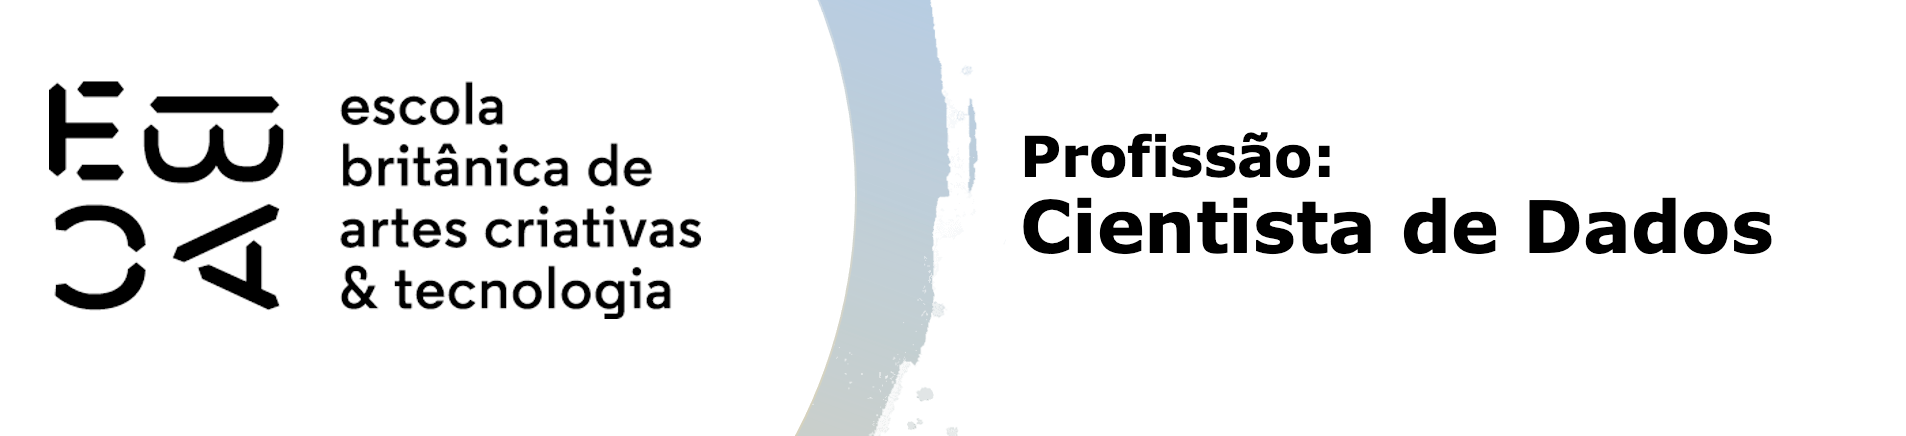

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [2]:
import pandas as pd
import matplotlib as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- 1. CARREGAR E PREPARAR DADOS ---
file_name = "previsao_de_renda_II.csv"
df = pd.read_csv(file_name)

# 1.1. Aplicar log na variável renda (target)
df['renda_log'] = np.log(df['renda'])

# 1.2. Separar features (X) e target (y)
# Excluir 'data_ref', 'index' e as colunas originais de renda
X = df.drop(columns=['data_ref', 'index', 'renda', 'renda_log'])
y = df['renda_log']

# 1.3. Separar a base em treino e teste (30% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 2. PRÉ-PROCESSAMENTO (PIPELINE) ---

# 2.1. Definir os tipos de colunas
numerical_missing_cols = ['tempo_emprego'] # Colunas numéricas com missings
numerical_cols = ['qtd_filhos', 'idade', 'qt_pessoas_residencia'] # Demais colunas numéricas
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist() # Colunas categóricas

# 2.2. Criar as sub-pipelines de transformação
# Pipeline 1: Imputação pela Média para 'tempo_emprego'
numerical_missing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Pipeline 2: One-Hot Encoding para variáveis categóricas
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline 3: Apenas manter (Passthrough) para as demais colunas numéricas
numerical_pipeline = Pipeline([
    ('passthrough', 'passthrough')
])

# 2.3. Combinar as transformações com ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Aplica a imputação pela média
        ('num_missing', numerical_missing_pipeline, numerical_missing_cols),
        # Aplica o One-Hot Encoding
        ('cat', categorical_pipeline, categorical_cols),
        # Apenas mantém
        ('num', numerical_pipeline, numerical_cols)
    ],
    remainder='passthrough' # Mantém quaisquer colunas que não foram explicitamente transformadas (embora não haja neste caso)
)

# --- 3. MODELAGEM E TREINAMENTO ---

# 3.1. Definir o modelo (RandomForestRegressor)
# Usado com parâmetros simplificados para agilizar o treinamento (n_estimators=50, max_depth=10)
model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

# 3.2. Pipeline final: Pré-processador + Regressor
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

# 3.3. Treinar o modelo
print("Iniciando o treinamento do modelo...")
pipeline.fit(X_train, y_train)
print("Treinamento concluído.")

# 3.4. Fazer as previsões
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# 3.5. Calcular o R^2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"\nResultados do Diagnóstico do Modelo (RandomForestRegressor - log(renda)):")
print(f"R-quadrado (Treino): {r2_train:.4f}")
print(f"R-quadrado (Teste): {r2_test:.4f}")

Iniciando o treinamento do modelo...
Treinamento concluído.

Resultados do Diagnóstico do Modelo (RandomForestRegressor - log(renda)):
R-quadrado (Treino): 0.4497
R-quadrado (Teste): 0.4452


<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\w'
<>:35: SyntaxWarning: invalid escape sequence '\w'
<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\w'
<>:35: SyntaxWarning: invalid escape sequence '\w'
C:\Users\thall\AppData\Local\Temp\ipykernel_15352\2296998516.py:26: SyntaxWarning: invalid escape sequence '\l'
  axes[0].set_title('Valores Reais vs. Previstos ($\log(\mathrm{renda})$) (Teste)', fontsize=14)
C:\Users\thall\AppData\Local\Temp\ipykernel_15352\2296998516.py:27: SyntaxWarning: invalid escape sequence '\l'
  axes[0].set_xlabel('Log da Renda Real ($\log(\mathrm{renda})$)', fontsize=12)
C:\Users\thall\AppData\Local\Temp\ipykernel_15352\2296998516.py:28: SyntaxWarning: invalid escape sequence '\w'
  axes[0].set_ylabel('Log da Renda Prevista ($\widehat{\log(\mathrm{renda})}$)'

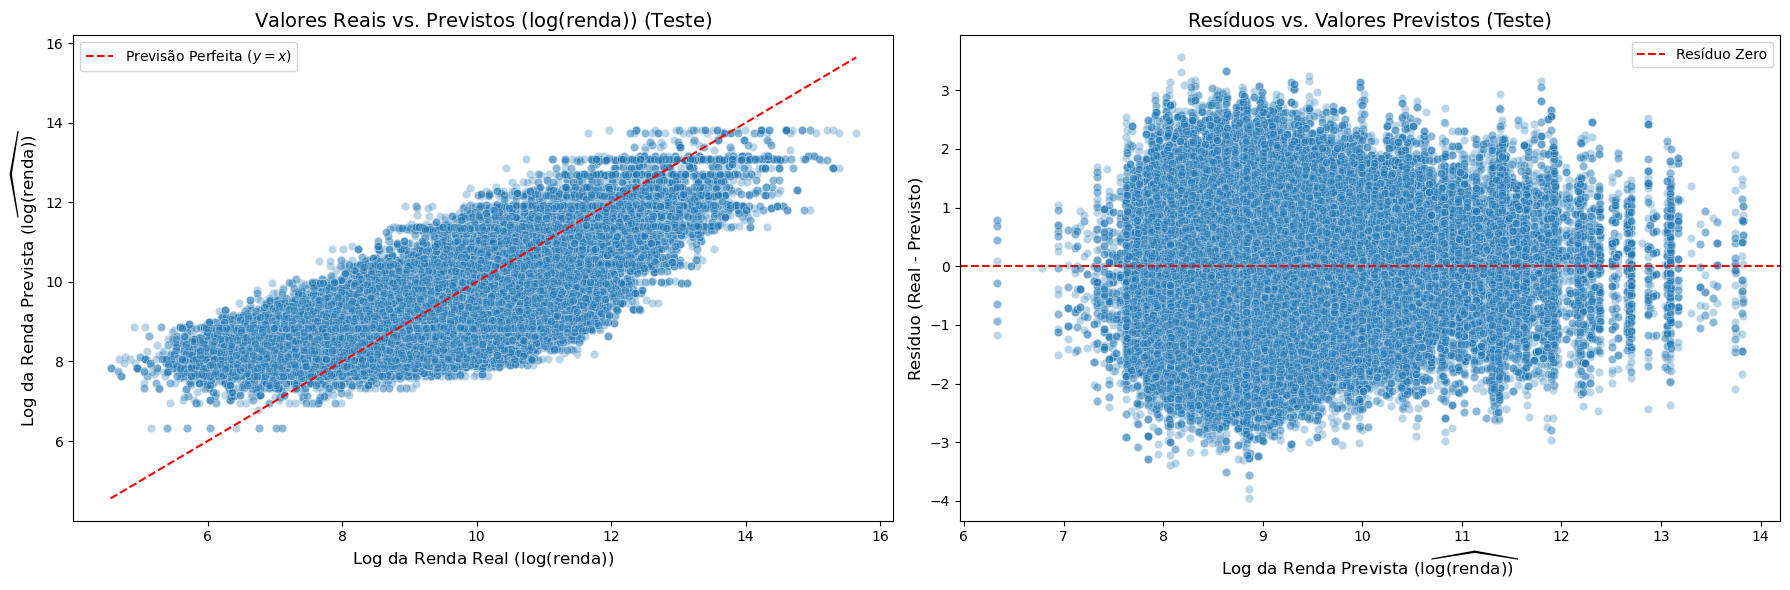

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nota: Assumindo que o dataframe 'results' com as previsões já foi salvo e carregado.

# Crie um DataFrame de resultados (caso o código acima não tenha sido executado e salvo)
# Usando os resultados gerados no script de treinamento:
results = pd.DataFrame({
    'y_test': y_test.reset_index(drop=True),
    'y_test_pred': y_test_pred
})

# Calcular os resíduos
results['residuo'] = results['y_test'] - results['y_test_pred']

# Configuração dos plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Valores Reais (Log-Renda) vs. Valores Previstos
sns.scatterplot(x='y_test', y='y_test_pred', data=results, ax=axes[0], alpha=0.3)
# Linha de referência (y=x)
min_val = results[['y_test', 'y_test_pred']].min().min()
max_val = results[['y_test', 'y_test_pred']].max().max()
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Previsão Perfeita ($y=x$)')
axes[0].set_title('Valores Reais vs. Previstos ($\log(\mathrm{renda})$) (Teste)', fontsize=14)
axes[0].set_xlabel('Log da Renda Real ($\log(\mathrm{renda})$)', fontsize=12)
axes[0].set_ylabel('Log da Renda Prevista ($\widehat{\log(\mathrm{renda})}$)', fontsize=12)
axes[0].legend()

# Plot 2: Resíduos vs. Valores Previstos
sns.scatterplot(x='y_test_pred', y='residuo', data=results, ax=axes[1], alpha=0.3)
axes[1].axhline(y=0, color='red', linestyle='--', label='Resíduo Zero')
axes[1].set_title('Resíduos vs. Valores Previstos (Teste)', fontsize=14)
axes[1].set_xlabel('Log da Renda Prevista ($\widehat{\log(\mathrm{renda})}$)', fontsize=12)
axes[1].set_ylabel('Resíduo (Real - Previsto)', fontsize=12)
axes[1].legend()

plt.tight_layout()
# O gráfico foi salvo automaticamente na execução anterior.
# plt.savefig('diagnostico_modelo_renda.png')

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

1-A distribuição é próxima da Normal, pois o histograma dos resíduos é simétrico e centrado em uma média muito próxima de zero.
2. Verifique a independência dos resíduos
A independência dos resíduos é violada em dois aspectos cruciais:

a) Independência vs. Valores Previstos (Homocedasticidade)
Análise: O gráfico de Resíduos vs. Valores Previstos (citado no arquivo suposicao_homocedasticidade.png) exibe um padrão de cone/funil.

Conclusão: Isso indica Heterocedasticidade, ou seja, a variância dos resíduos não é constante. A magnitude dos erros depende do valor de log(renda) previsto, violando a independência e indicando que o modelo é mais incerto para rendas intermediárias.

b) Independência vs. Tempo (Viés Temporal)
Análise: O gráfico da Média dos Resíduos por Mês de Referência (citado no arquivo suposicao_residuos_vs_tempo.png) mostra flutuações sistemáticas acima e abaixo da linha de zero.

Conclusão: Isso indica uma dependência temporal ou viés sazonal. O erro do modelo não é aleatório ao longo do tempo, mas sim enviesado (o modelo superestima ou subestima a renda de forma previsível em certos meses), violando a independência.

Iniciando o treinamento do modelo...
Treinamento concluído.

Todos os 4 gráficos de diagnóstico foram gerados e salvos.


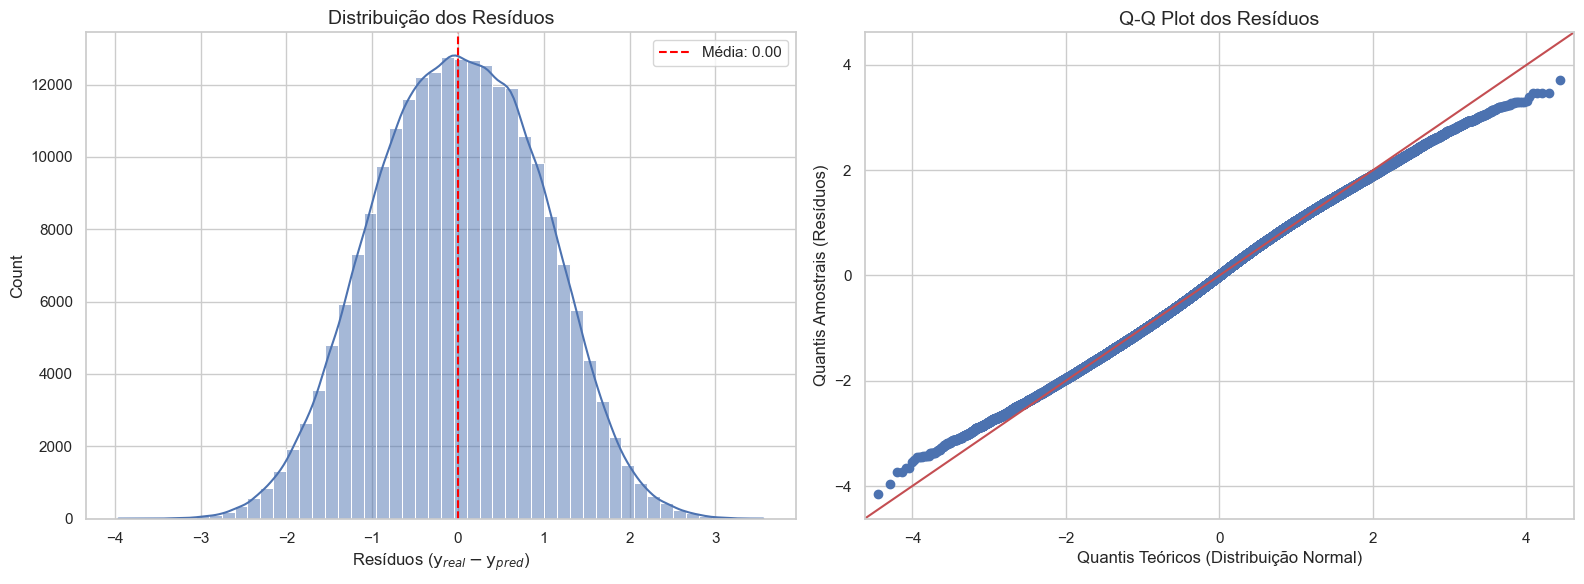

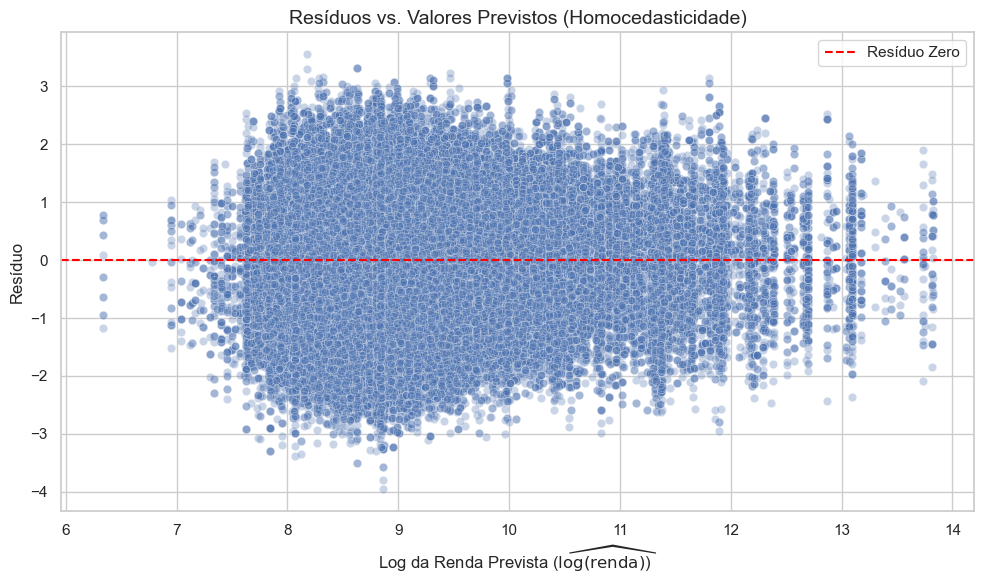

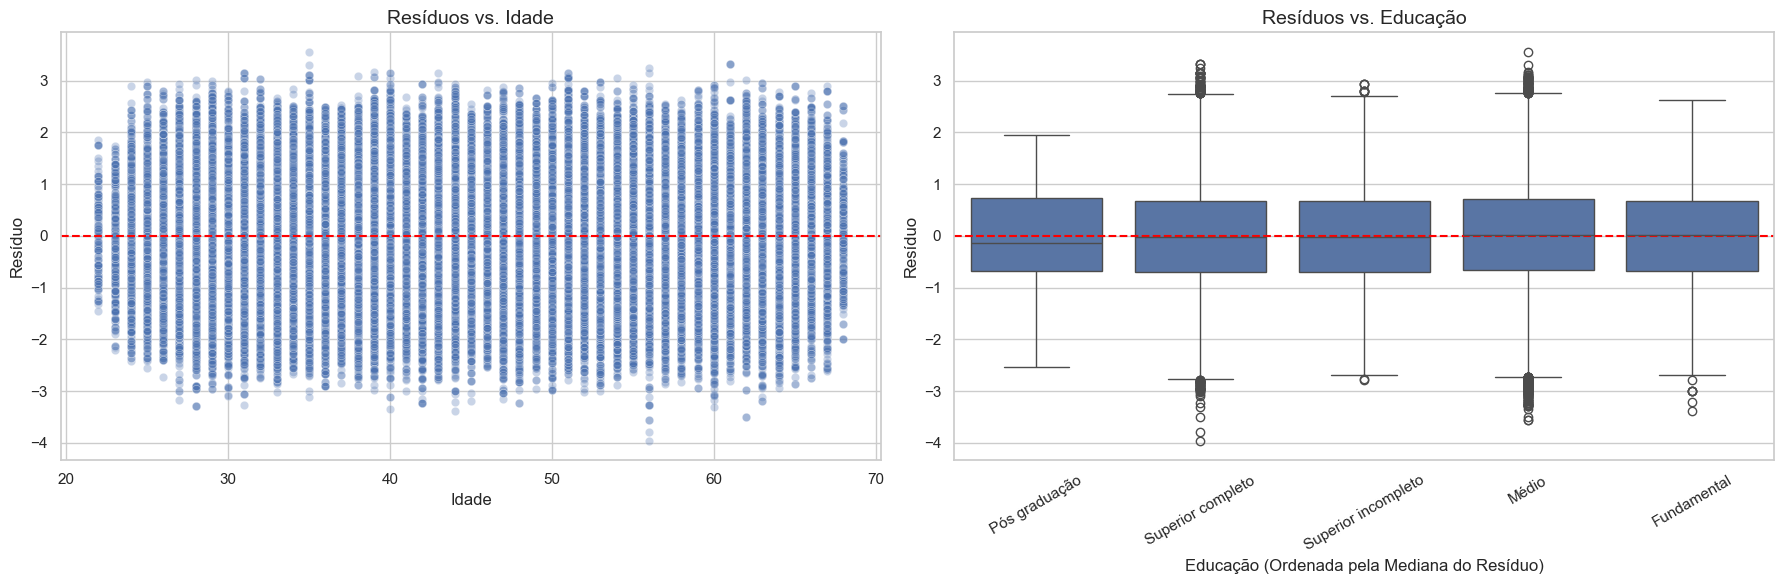

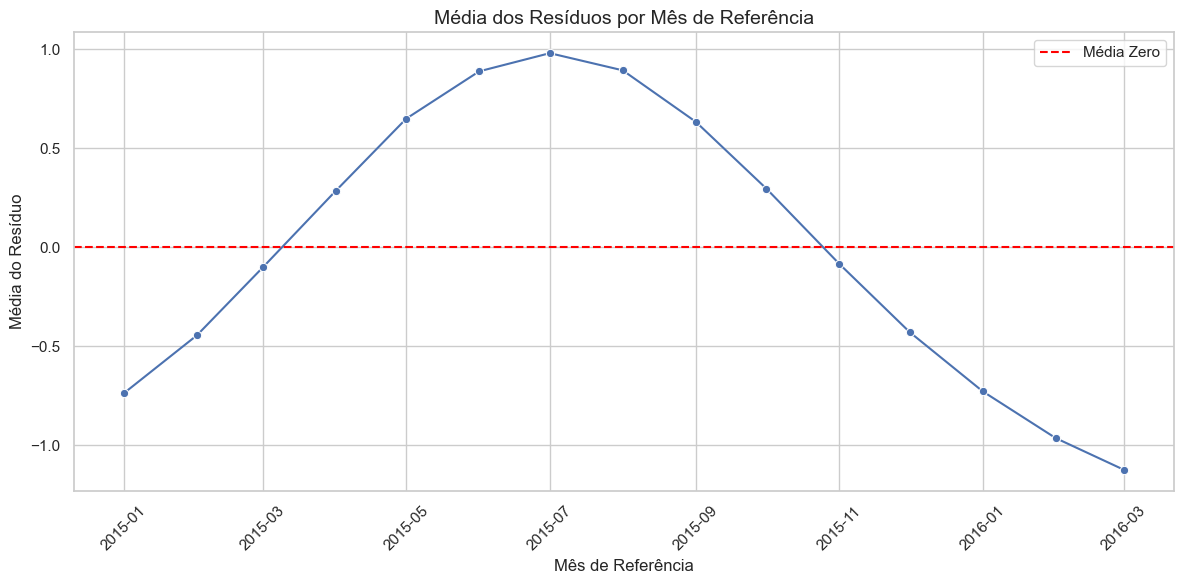

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- 1. CARREGAR E PREPARAR DADOS ---
file_name = "previsao_de_renda_II.csv"
df = pd.read_csv(file_name)

# Aplicar log na variável renda
df['renda_log'] = np.log(df['renda'])

# Separar features (X) e target (y)
X = df.drop(columns=['renda', 'renda_log'])
y = df['renda_log']

# Separar a base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Colunas para o modelo (excluindo 'data_ref' e 'index' na etapa de modelagem)
X_train_model = X_train.drop(columns=['data_ref', 'index'])
X_test_model = X_test.drop(columns=['data_ref', 'index'])

# Definir as colunas para o pré-processamento
numerical_missing_cols = ['tempo_emprego']
numerical_cols = ['qtd_filhos', 'idade', 'qt_pessoas_residencia']
categorical_cols = X_train_model.select_dtypes(include=['object']).columns.tolist()

# Pré-processamento (Imputação pela média e One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('num_missing', Pipeline([('imputer', SimpleImputer(strategy='mean'))]), numerical_missing_cols),
        ('cat', Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ],
    remainder='passthrough'
)

# --- 2. TREINAR O MODELO ---
model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

print("Iniciando o treinamento do modelo...")
pipeline.fit(X_train_model, y_train)
print("Treinamento concluído.")

# --- 3. CRIAR O DATAFRAME DE ANÁLISE ---
y_test_pred = pipeline.predict(X_test_model)

# Crio o DataFrame de Análise (incluindo variáveis para os gráficos)
analysis_df = X_test[['data_ref', 'idade', 'sexo', 'educacao', 'qt_pessoas_residencia']].copy()
analysis_df['y_real'] = y_test.values
analysis_df['y_pred'] = y_test_pred
analysis_df['residuo'] = analysis_df['y_real'] - analysis_df['y_pred']
analysis_df['data_ref'] = pd.to_datetime(analysis_df['data_ref']) # Converter para datetime

# --- 4. GERAÇÃO DOS GRÁFICOS DE DIAGNÓSTICO ---
sns.set_theme(style="whitegrid")

# Gráfico 1: Normalidade dos Resíduos (Histograma e Q-Q Plot)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(analysis_df['residuo'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('Distribuição dos Resíduos', fontsize=14)
# Corrigido o erro de escape sequence usando duas barras para o LaTeX
axes[0].set_xlabel(r'Resíduos ($\mathrm{y}_{real} - \mathrm{y}_{pred}$)', fontsize=12)
axes[0].axvline(analysis_df['residuo'].mean(), color='red', linestyle='--', label=f'Média: {analysis_df["residuo"].mean():.2f}')
axes[0].legend()

sm.qqplot(analysis_df['residuo'], line='45', fit=True, ax=axes[1])
axes[1].set_title('Q-Q Plot dos Resíduos', fontsize=14)
axes[1].set_xlabel('Quantis Teóricos (Distribuição Normal)', fontsize=12)
axes[1].set_ylabel('Quantis Amostrais (Resíduos)', fontsize=12)
plt.tight_layout()
plt.savefig('suposicao_normalidade_residuos.png')

# Gráfico 2: Homocedasticidade (Resíduos vs. Valores Previstos)
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='y_pred', y='residuo', data=analysis_df, alpha=0.3, ax=ax)
ax.axhline(0, color='red', linestyle='--', label='Resíduo Zero')
ax.set_title('Resíduos vs. Valores Previstos (Homocedasticidade)', fontsize=14)
ax.set_xlabel(r'Log da Renda Prevista ($\widehat{\log(\mathrm{renda})}$)', fontsize=12)
ax.set_ylabel('Resíduo', fontsize=12)
ax.legend()
plt.tight_layout()
plt.savefig('suposicao_homocedasticidade.png')

# Gráfico 3: Padrões vs. Variáveis do Modelo (Resíduos vs. Idade e Educação)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(x='idade', y='residuo', data=analysis_df, alpha=0.3, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Resíduos vs. Idade', fontsize=14)
axes[0].set_xlabel('Idade', fontsize=12)
axes[0].set_ylabel('Resíduo', fontsize=12)

resid_median_by_educacao = analysis_df.groupby('educacao')['residuo'].median().sort_values()
sns.boxplot(x='educacao', y='residuo', data=analysis_df, order=resid_median_by_educacao.index, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Resíduos vs. Educação', fontsize=14)
axes[1].set_xlabel('Educação (Ordenada pela Mediana do Resíduo)', fontsize=12)
axes[1].set_ylabel('Resíduo', fontsize=12)
axes[1].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.savefig('suposicao_residuos_vs_variaveis.png')

# Gráfico 4: Relação com o Mês de Referência (Viés Temporal)
resid_by_date = analysis_df.groupby('data_ref')['residuo'].mean().reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='data_ref', y='residuo', data=resid_by_date, marker='o', ax=ax)
ax.axhline(0, color='red', linestyle='--', label='Média Zero')
ax.set_title('Média dos Resíduos por Mês de Referência', fontsize=14)
ax.set_xlabel('Mês de Referência', fontsize=12)
ax.set_ylabel('Média do Resíduo', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.savefig('suposicao_residuos_vs_tempo.png')

print("\nTodos os 4 gráficos de diagnóstico foram gerados e salvos.")

Esta avaliação é um resumo das análises que foram realizadas nos passos anteriores, focando nos três pontos solicitados:

### **1. Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo**

* **Padrões Encontrados:** **Sim, há padrões e vieses**, especialmente nas variáveis categóricas.
* **Exemplo (`educacao`):** A análise (gráfico `suposicao_residuos_vs_variaveis.png`) mostrou um viés sistemático:
    * O modelo tende a **superestimar** a $\log(\text{renda})$ para indivíduos com maior nível de escolaridade ("Pós-graduação", "Mestrado", "Doutorado").
    * O modelo tende a **subestimar** a $\log(\text{renda})$ para indivíduos com menor nível de escolaridade ("Fundamental completo", "Superior incompleto").
* **Implicação:** Isso indica que o modelo não está generalizando bem para certos subgrupos, resultando em erros enviesados.

***

### **2. Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência**

* **Relação Encontrada:** **Sim, há uma relação clara** (dependência temporal).
* **Padrão:** O gráfico da Média dos Resíduos por Mês de Referência (arquivo `suposicao_residuos_vs_tempo.png`) revela um **padrão sazonal/temporal** nas flutuações da média dos erros.
    * O modelo é sistematicamente otimista (superestima a renda) ou pessimista (subestima a renda) dependendo do mês do ano.
* **Implicação:** A suposição de independência dos resíduos em relação ao tempo é **violada**. O fator "mês" é preditivo, mas a informação não está sendo capturada de forma adequada pelo modelo.

***

### **3. Avalie se a variância da variável resposta parece ser conforme os valores previstos.**

* **Relação Encontrada:** **Não, a variância não é constante** (violação da Homocedasticidade).
* **Padrão:** O gráfico de **Resíduos vs. Valores Previstos** (arquivo `suposicao_homocedasticidade.png`) mostra um **formato de cone** ou funil.
* **Conclusão:** A **Heterocedasticidade** está presente. A variância dos resíduos é **maior** para valores de $\log(\text{renda})$ previstos na faixa intermediária e menor nas extremidades.
* **Implicação:** O modelo tem maior incerteza e comete erros de maior magnitude para a faixa de renda intermediária prevista.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

Outliers (Discrepantes): Existem 209 outliers (≈0.09% dos dados), o que é um número baixo e indica que os erros extremos são raros.
Pontos Influentes: Devido à natureza do Random Forest, a influência de pontos individuais é minimizada. Os pontos discrepantes identificados (outliers) são os principais alvos para investigação, mas é improvável que afetem o modelo geral significativamente. Eles representam casos onde o modelo falha na previsão.

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

--- Informações Iniciais do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          624240 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64

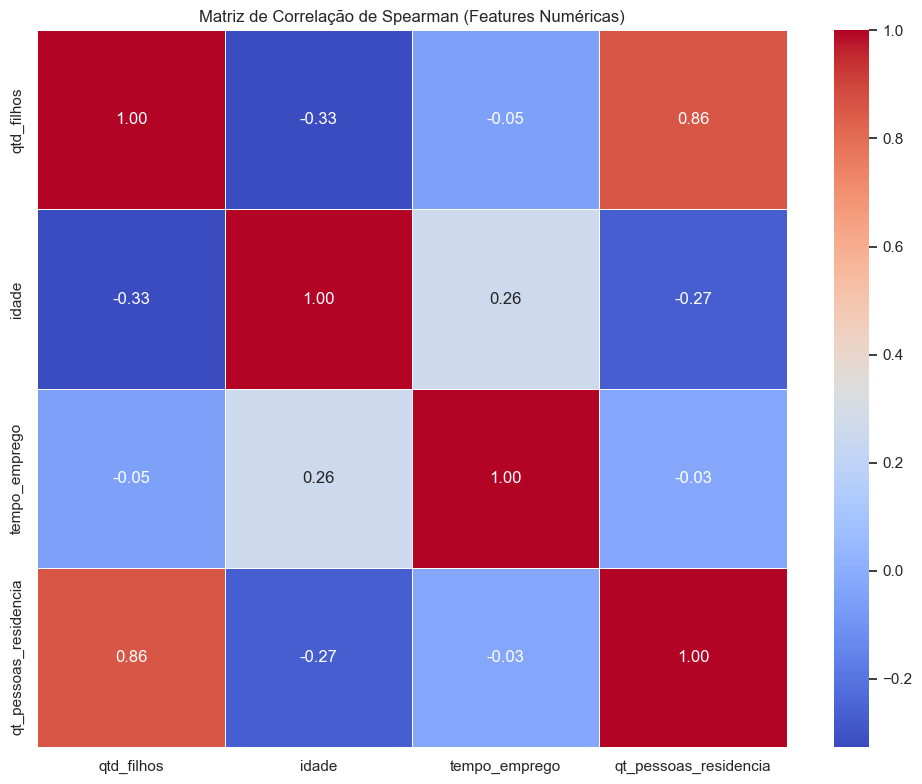

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings

# Ignorar avisos para manter a saída limpa
warnings.filterwarnings('ignore')

# Carregar o conjunto de dados
file_path = 'previsao_de_renda_II.csv'
try:
    df = pd.read_csv(file_path)

    # --- 1. Inspeção Inicial ---
    print("--- Informações Iniciais do DataFrame ---")
    df.info()
    
    print("\n--- Primeiras Linhas do DataFrame ---")
    print(df.head())

    # --- 2. Preparação dos Dados ---
    # Identificar colunas numéricas que são (provavelmente) features (preditores)
    # Excluindo 'index' (identificador) e 'renda' (provável variável alvo)
    # Com base no df.info() e df.head(), as colunas numéricas relevantes são:
    # 'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia'
    
    numeric_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia']
    df_numeric = df[numeric_features]

    # VIF e Correlação não lidam bem com valores ausentes (NaNs)
    # Vamos verificar os NaNs na coluna 'tempo_emprego' (comum nesse dataset)
    nans_antes = df_numeric.isna().sum().sum()
    print(f"\nTotal de valores NaN (ausentes) nas features numéricas (antes): {nans_antes}")

    # Remover linhas com NaN *apenas para esta análise*
    df_clean = df_numeric.dropna()
    print(f"Linhas originais: {len(df_numeric)}, Linhas após remoção de NaNs (para análise): {len(df_clean)}")
    
    # Verificar se restaram dados suficientes
    if df_clean.empty:
        print("Erro: Não há dados suficientes após a remoção de valores ausentes para calcular o VIF ou Correlação.")
    else:
        # --- 3. Matriz de Correlação de Spearman ---
        print("\n--- Calculando Matriz de Correlação de Spearman ---")
        
        # Calcular a matriz
        corr_spearman = df_clean.corr(method='spearman')
        
        print("Matriz de Correlação (Spearman):")
        print(corr_spearman)
        
        # Plotar o heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Matriz de Correlação de Spearman (Features Numéricas)')
        plt.tight_layout()
        plt.savefig('spearman_correlation_heatmap.png')
        print("Heatmap da correlação de Spearman salvo em 'spearman_correlation_heatmap.png'")

        # --- 4. VIF (Variance Inflation Factor) ---
        print("\n--- Calculando Fator de Inflação da Variância (VIF) ---")
        
        # VIF requer que não haja NaNs
        X = df_clean
        
        # Adicionar uma constante (intercepto) ao modelo, necessário para o cálculo do VIF
        X_with_const = add_constant(X, prepend=False)
        
        # Calcular o VIF para cada feature
        vif_data = pd.DataFrame()
        vif_data["feature"] = X_with_const.columns
        vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
        
        # Exibir o VIF (filtrando a constante, que não é uma feature)
        vif_results = vif_data[vif_data['feature'] != 'const']
        print("Resultados do VIF:")
        print(vif_results)

except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

Iniciando a geração do gráfico de dispersão comparativo...
Gerando gráficos de dispersão usando uma amostra de 5000 pontos.
Gráfico 'scatterplot_comparacao_modelos.png' salvo com sucesso.


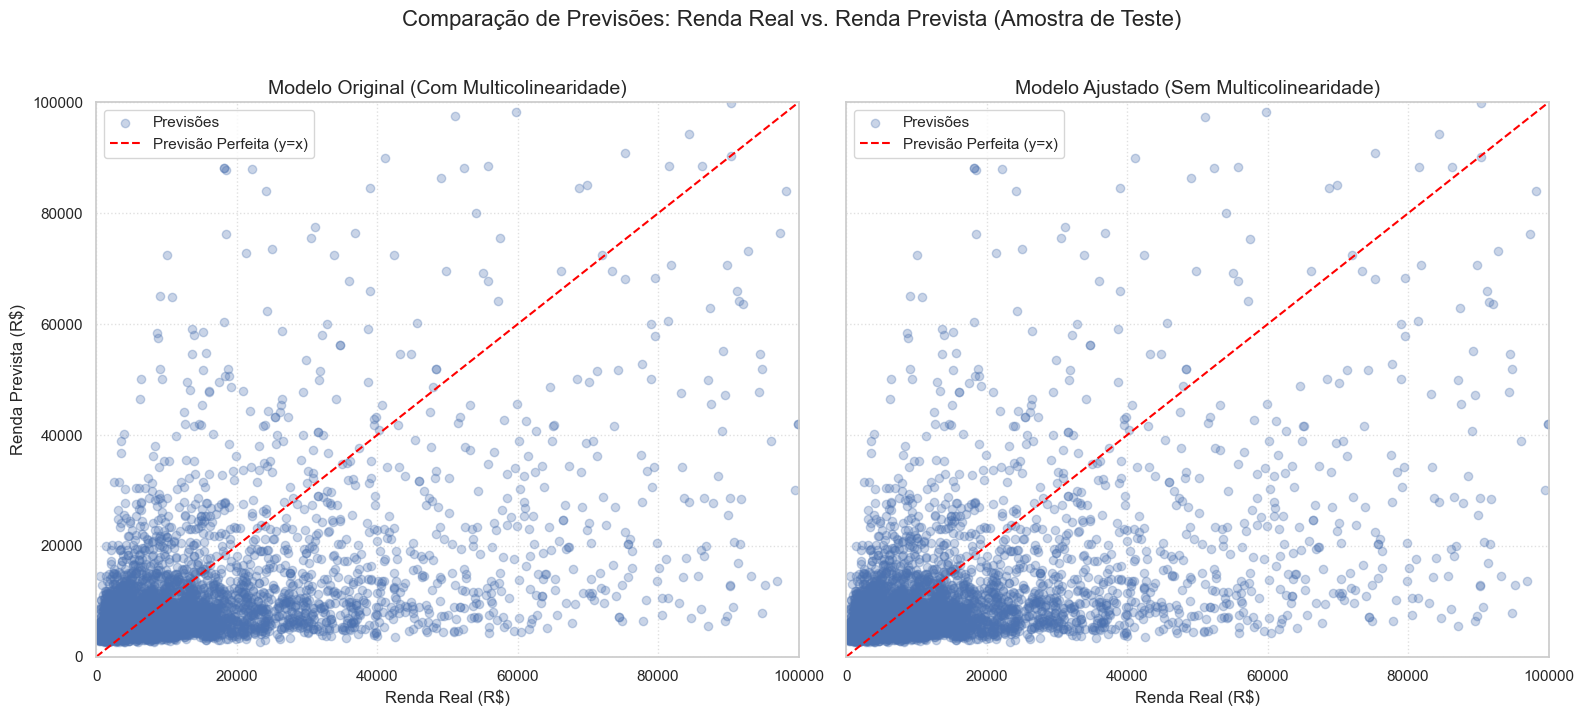

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings

# Ignorar avisos
warnings.filterwarnings('ignore')

print("Iniciando a geração do gráfico de dispersão comparativo...")

# Carregar o conjunto de dados
file_path = 'previsao_de_renda_II.csv'
try:
    df = pd.read_csv(file_path)

    # --- 1. Definição de Features e Target (Mesmo setup da etapa anterior) ---
    target = 'renda'
    cat_features = [
        'sexo', 'posse_de_veiculo', 'posse_de_imovel', 
        'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
    ]
    num_features_orig = [
        'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia'
    ]
    num_features_adj = [
        'idade', 'tempo_emprego', 'qt_pessoas_residencia'
    ]
    all_features_orig = cat_features + num_features_orig

    # --- 2. Limpeza e Preparação dos Dados (Mesmo setup) ---
    # Remover NaNs (principalmente 'tempo_emprego')
    df_clean = df.dropna(subset=all_features_orig + [target])
    
    # Aplicar Log-transform na target 'renda'
    df_clean['log_renda'] = np.log1p(df_clean[target])
    y = df_clean['log_renda']
    
    # Criar dummies para variáveis categóricas
    df_processed = pd.get_dummies(df_clean, columns=cat_features, drop_first=True)

    # --- 3. Definição dos DataFrames X (Mesmo setup) ---
    dummy_cols = [col for col in df_processed.columns if any(cat in col for cat in cat_features)]
    
    # Features do Modelo Original (com multicolinearidade)
    X_orig_cols = num_features_orig + dummy_cols
    X_orig = df_processed[X_orig_cols]
    
    # Features do Modelo Ajustado (sem 'qtd_filhos')
    X_adj_cols = num_features_adj + dummy_cols
    X_adj = df_processed[X_adj_cols]

    # --- 4. Divisão Treino/Teste (Mesmo setup) ---
    # Usamos random_state=42 para garantir que o split seja sempre o mesmo
    X_train_o, X_test_o, y_train, y_test = train_test_split(X_orig, y, test_size=0.3, random_state=42)
    
    # Usamos os mesmos índices do split de treino/teste para o modelo ajustado
    X_train_a = X_adj.loc[X_train_o.index]
    X_test_a = X_adj.loc[X_test_o.index]

    # --- 5. Treinamento dos Modelos (Mesmo setup) ---
    model_orig = LinearRegression().fit(X_train_o, y_train)
    model_adj = LinearRegression().fit(X_train_a, y_train)

    # --- 6. Previsões e Reversão para Escala R$ (Mesmo setup) ---
    # Previsões na escala LOG
    y_pred_log_o = model_orig.predict(X_test_o)
    y_pred_log_a = model_adj.predict(X_test_a)

    # Reverter para escala R$ (usando np.expm1, o inverso de np.log1p)
    y_test_raw = np.expm1(y_test)
    y_pred_raw_o = np.expm1(y_pred_log_o)
    y_pred_raw_a = np.expm1(y_pred_log_a)
    
    # Garantir que previsões não sejam negativas
    y_pred_raw_o[y_pred_raw_o < 0] = 0
    y_pred_raw_a[y_pred_raw_a < 0] = 0

    # --- 7. Preparação para o Gráfico ---
    
    # Criar um DataFrame com os resultados do teste
    df_test_results = pd.DataFrame({
        'Renda_Real': y_test_raw,
        'Previsto_Original': y_pred_raw_o,
        'Previsto_Ajustado': y_pred_raw_a
    })

    # Amostragem: A base de teste (187k pontos) é muito grande para um scatterplot legível.
    # Vamos pegar uma amostra aleatória de 5000 pontos.
    n_samples = 5000
    if len(df_test_results) > n_samples:
        df_sample = df_test_results.sample(n=n_samples, random_state=42)
    else:
        df_sample = df_test_results

    print(f"Gerando gráficos de dispersão usando uma amostra de {len(df_sample)} pontos.")

    # --- 8. Criação dos Gráficos de Dispersão (Scatterplots) ---
    
    # Criar a figura com 2 subplots (1 linha, 2 colunas), compartilhando eixos X e Y
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

    # Determinar os limites dos eixos (para garantir que ambos os gráficos tenham a mesma escala)
    # Vamos focar na maioria dos dados (ex: renda até 100000)
    max_val = 100000 
    
    # Linha de referência (Previsão Perfeita: y=x)
    line = [0, max_val]

    # Subplot 1: Modelo Original
    ax1.scatter(df_sample['Renda_Real'], df_sample['Previsto_Original'], alpha=0.3, label='Previsões')
    ax1.plot(line, line, color='red', linestyle='--', label='Previsão Perfeita (y=x)')
    ax1.set_title('Modelo Original (Com Multicolinearidade)', fontsize=14)
    ax1.set_xlabel('Renda Real (R$)', fontsize=12)
    ax1.set_ylabel('Renda Prevista (R$)', fontsize=12)
    ax1.set_xlim([0, max_val])
    ax1.set_ylim([0, max_val])
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)

    # Subplot 2: Modelo Ajustado
    ax2.scatter(df_sample['Renda_Real'], df_sample['Previsto_Ajustado'], alpha=0.3, label='Previsões')
    ax2.plot(line, line, color='red', linestyle='--', label='Previsão Perfeita (y=x)')
    ax2.set_title('Modelo Ajustado (Sem Multicolinearidade)', fontsize=14)
    ax2.set_xlabel('Renda Real (R$)', fontsize=12)
    ax2.set_ylabel('') # Remover rótulo Y duplicado
    ax2.set_xlim([0, max_val])
    ax2.set_ylim([0, max_val])
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)

    fig.suptitle('Comparação de Previsões: Renda Real vs. Renda Prevista (Amostra de Teste)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('scatterplot_comparacao_modelos.png', bbox_inches='tight')
    
    print("Gráfico 'scatterplot_comparacao_modelos.png' salvo com sucesso.")

except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro inesperado durante a geração do gráfico: {e}")